In [148]:
import torch
import numpy as np
import librosa
import librosa.display as ld
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.signal as scisig
from scipy import ndimage
import cv2

In [7]:
recs = list(Path("~/FL Studio/Audio Recordings/Audio")
            .expanduser()
            .glob("*_REC.wav"))
recs

[WindowsPath('C:/Users/George Tzoupis/FL Studio/Audio Recordings/Audio/Audio Recordings_2024-09-19 22-35-04_REC.wav'),
 WindowsPath('C:/Users/George Tzoupis/FL Studio/Audio Recordings/Audio/Audio Recordings_2024-09-19 22-47-39_REC.wav'),
 WindowsPath('C:/Users/George Tzoupis/FL Studio/Audio Recordings/Audio/Audio Recordings_2024-09-19 22-51-48_REC.wav')]

In [257]:
x, sr = librosa.load(recs[2], sr=None, mono=True)
print(f"sr={sr}")
print(f"x.shape={x.shape}")
print(f"duration={x.shape[-1] / sr:.3f} sec")

sr=44100
x.shape=(765911,)
duration=17.368 sec


In [258]:
stft_settings = dict(n_fft=2048, hop_length=512)
X = librosa.stft(x, **stft_settings) / stft_settings["n_fft"]

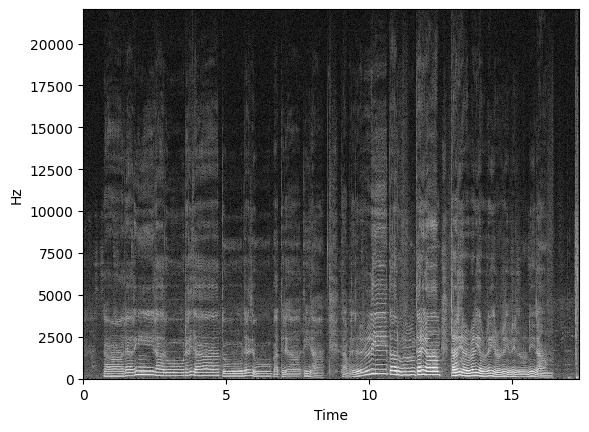

In [259]:
x_mag = np.abs(X)
x_logmag = 20 * np.log10(x_mag + 1e-6)

ld.specshow(data=x_logmag, sr=sr, x_axis="time", y_axis="hz", cmap="gray", **stft_settings)

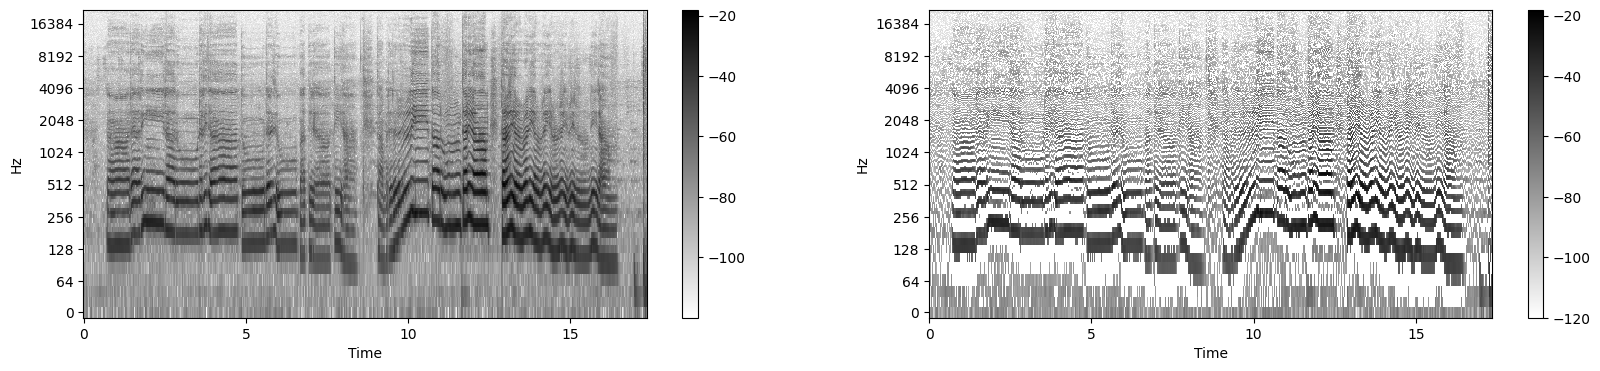

In [298]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
ld.specshow(data=x_logmag, sr=sr, x_axis="time", y_axis="log", cmap="gray_r", **stft_settings)
plt.colorbar()

plt.subplot(1, 2, 2)
coeffs = scisig.butter(2, 0.3, 'low')
xi = scisig.filtfilt(*coeffs, x_logmag, axis=0)
coeffs = scisig.butter(2, 0.5, 'high')
xi = scisig.filtfilt(*coeffs, xi, axis=0)
# xi = np.sqrt(ndimage.sobel(xi, 0) ** 2 + ndimage.sobel(xi, 1) ** 2)
# xi = ndimage.gaussian_filter(xi, sigma=2)
xi -= xi.min()
xi /= xi.max()
xi = xi > 0.5
# coeffs = scisig.butter(2, 0.28, 'low')
# xi = scisig.filtfilt(*coeffs, xi, axis=0)
# xi -= xi.min()
# xi /= xi.max()
# xi = xi > 0.8
xi = xi ** 4

ld.specshow(data=20 * np.log10(xi * x_mag + 1e-6), sr=sr, x_axis="time", y_axis="log", cmap="gray_r", **stft_settings)
# ld.specshow(data=xi, sr=sr, x_axis="time", y_axis="log", cmap="gray_r", **stft_settings)
plt.colorbar()

# plt.imshow(edge, aspect='auto', cmap="gray", origin='lower')

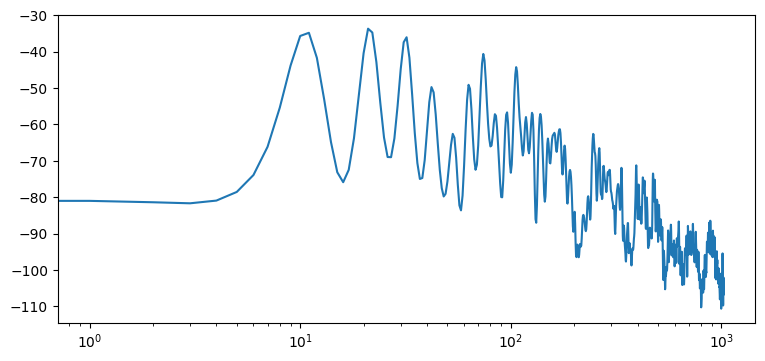

In [262]:
xi = x_logmag[:, int(12 * (sr / stft_settings["hop_length"]))]

coeffs = scisig.butter(2, .3, 'low')
xi = scisig.filtfilt(*coeffs, xi)


plt.figure(figsize=(9, 4))
plt.semilogx(xi)

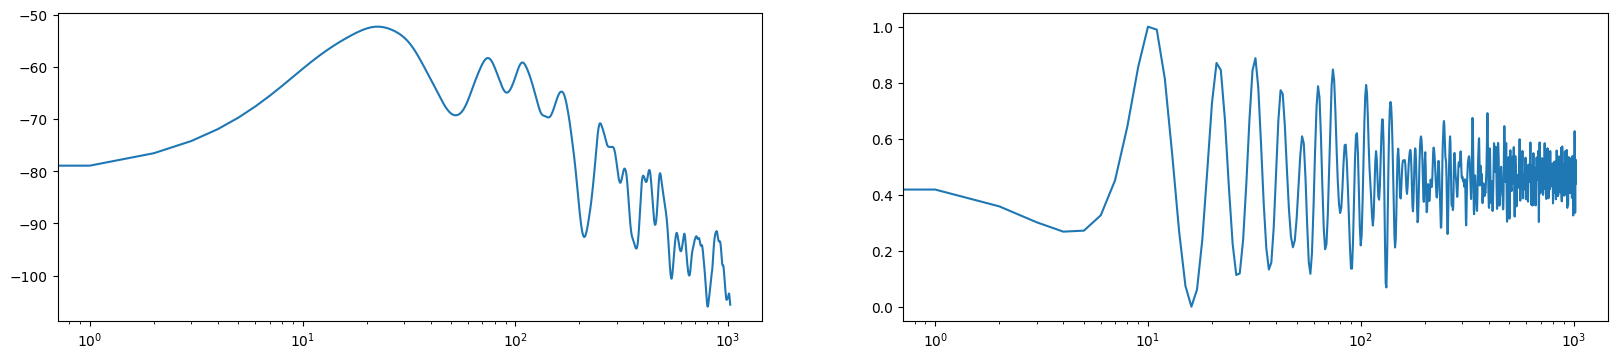

In [278]:
Wn = .05

low_coeffs = scisig.butter(2, Wn, 'low')
high_coeffs = scisig.butter(2, Wn, 'high')

xi_low = scisig.filtfilt(*low_coeffs, xi)
xi_high = scisig.filtfilt(*high_coeffs, xi)

xi_high -= xi_high.min()
xi_high /= xi_high.max()
# xi_high[xi_high < 0.5] = 0
# xi_high = xi_high > 0.9

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.semilogx(xi_low)

plt.subplot(1, 2, 2)
plt.semilogx(xi_high)


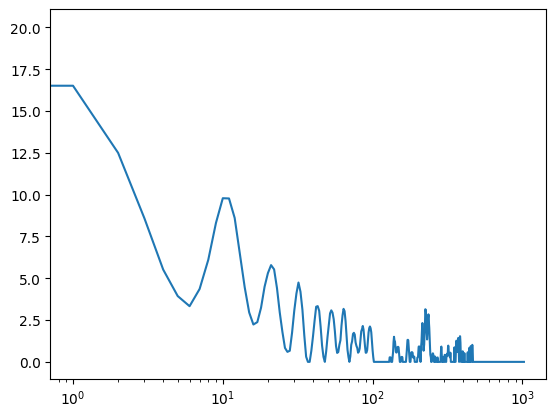

In [276]:
corr = scisig.correlate(xi_high, xi_high)
lags = scisig.correlation_lags(len(xi_high), len(xi_high))
plt.semilogx(lags[len(corr) // 2:], corr[len(corr) // 2:])